In [1]:
from pandas import DataFrame,concat,read_excel
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM,Dense,Dropout
from numpy import concatenate
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score
from math import sqrt,sin,pi
import plotly.graph_objs as go
from plotly.offline import plot
import pandas as pd
import chart_studio.plotly as py

Using TensorFlow backend.


In [2]:
from pandas_datareader import data as pdr
# Core code, set the display of the maximum column, width and other parameters, eliminate the printing of incomplete medial ellipsis
pd.set_option('display.max_columns', 1000)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', 1000)

In [3]:
start_date = '2014-01-01'
end_date = '2019-12-31'
data = pdr.get_data_yahoo('TXN', start_date, end_date)
data.to_csv(r'/Users/thxq24302/Desktop/Algorithmic and High-Frequency/Group Assignment/data_fiveyears.csv', columns=data.columns, index=True)

In [4]:
data.describe()

,High,Low,Open,Close,Volume,Adj Close
count,1511.000000,1511.000000,1511.000000,1511.000000,1.511000e+03,1511.000000
mean,79.065453,77.627181,78.347730,78.380437,5.595568e+06,73.121983
std,26.976700,26.428142,26.715071,26.714448,2.765175e+06,27.910059
min,41.130001,40.330002,40.630001,40.889999,1.288300e+06,34.929714
25%,54.379999,53.344999,53.840000,53.870001,3.879700e+06,47.505043
50%,74.690002,73.980003,74.250000,74.199997,4.943600e+06,68.123672
75%,105.674999,103.609997,104.590000,104.545002,6.502000e+06,99.702892
max,132.199997,129.789993,130.899994,131.690002,3.322960e+07,129.767319


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1511 entries, 2013-12-31 to 2019-12-31
Data columns (total 6 columns):
High         1511 non-null float64
Low          1511 non-null float64
Open         1511 non-null float64
Close        1511 non-null float64
Volume       1511 non-null float64
Adj Close    1511 non-null float64
dtypes: float64(6)
memory usage: 82.6 KB


In [6]:
data  =pd.read_csv(r'/Users/thxq24302/Desktop/Algorithmic and High-Frequency/Group Assignment/data_fiveyears.csv',parse_dates=['Date'],index_col='Date')
data_t = pd.read_csv(r'/Users/thxq24302/Desktop/Algorithmic and High-Frequency/Group Assignment/data_fiveyears.csv')

In [7]:
def moving_average(x, n, type='simple'):
    x = np.asarray(x)
    if type == 'simple':
        weights = np.ones(n)
    else:
        weights = np.exp(np.linspace(-1., 0., n))
    weights /= weights.sum()
    a = np.convolve(x, weights, mode='full')[:len(x)]
    a[:n] = a[n]
    return a

In [8]:
data["MA5_Close"] = moving_average(data['Close'], 5, 'simple')
data["MA10_Close"] = moving_average(data['Close'], 10, 'simple')
data["MA5_Volume"] = moving_average(data['Volume'], 5, 'simple')
data["MA10_Volume"] = moving_average(data['Volume'], 10, 'simple')

In [9]:
data.head()

,High,Low,Open,Close,Volume,Adj Close,MA5_Close,MA10_Close,MA5_Volume,MA10_Volume
Date,,,,,,,,,,
2013-12-31,44.090000,43.790001,44.040001,43.910000,2631300.0,37.247204,43.062,43.060001,5506240.0,5650310.0
2014-01-02,43.500000,42.880001,43.439999,43.099998,6959200.0,36.560108,43.062,43.060001,5506240.0,5650310.0
2014-01-03,43.459999,42.970001,43.119999,43.290001,4693300.0,36.721279,43.062,43.060001,5506240.0,5650310.0
2014-01-06,43.279999,42.849998,43.250000,42.930000,4446300.0,36.415901,43.062,43.060001,5506240.0,5650310.0
2014-01-07,43.110001,42.639999,42.980000,42.700001,5078900.0,36.220810,43.062,43.060001,5506240.0,5650310.0


In [11]:
# py.sign_in('API name', 'API')
py.sign_in('thxq24302', 'XM84hNdT1KJxmwlkTthx')
txndata = [go.Scatter(x=data_t['Date'],y=data['MA5_Close'],name='MA5_Close'),
            go.Scatter(x=data_t['Date'],y=data['MA10_Close'],name='MA10_Close')]
layout = go.Layout(title='TXN-Close')
fig = go.Figure(data=txndata, layout=layout)
py.iplot(fig)

In [12]:
txn_volume = go.Bar(
    x=data.index,
    y=data['Volume'],
    marker=dict(color='#fff143',
                line=dict(color='rgb(255, 102, 102)',width=1.0,)),name='Volume',
    opacity=0.9)
Barfig = go.Figure(data=txn_volume)
py.iplot(Barfig,name='Volume')

In [13]:
txn_Ma_Volume = [go.Bar(x=data_t['Date'],y=data['MA5_Volume'],marker=dict(color='#fff143',
                line=dict(color='rgb(255, 51, 51)',width=1.0,)),
                        name='MA5_Volume'),
            go.Bar(x=data_t['Date'],y=data['MA10_Volume'],marker=dict(color='#fff143',
                line=dict(color='rgb(51, 153, 255)',width=1.0,)),name='MA10_Volume')]
layout = go.Layout(title='txn_Ma_Volume')
MA_Volume= go.Figure(data=txn_Ma_Volume, layout=layout)
py.iplot(MA_Volume,name='MA_Volume')

In [14]:
def meaning(data,N): # Stock investing strategy
    S=1000000 # Principle holding value
    P=0 # Stock holding value
    Y=0 # Commission
    F=0 # Yield rate
    for i in range(2,N):
        if data["MA5_Close"][i]>data["MA10_Close"][i] and data["MA5_Close"][i-1]>=data["MA10_Close"][i-1] \
                and data["MA5_Close"][i-2]<data["MA10_Close"][i-2] and data["MA5_Volume"][i]>data["MA10_Volume"][i]\
                and data["MA5_Volume"][i-1]>=data["MA10_Volume"][i-1] and data["MA5_Volume"][i-2]<data["MA10_Volume"][i-2]:
            n=int(S/float(data["Close"][i]))# Shares purchased
            P=P+n
            S=S-n*float(data["Close"][i])*1.0002
            Y=Y+n*float(data["Close"][i])*0.0002
        elif data["MA5_Close"][i]<data["MA10_Close"][i] and data["MA5_Close"][i-1]<=data["MA10_Close"][i-1] \
                and data["MA5_Close"][i-2]>data["MA10_Close"][i-2] and data["MA5_Volume"][i]<data["MA10_Volume"][i]\
                and data["MA5_Volume"][i-1]<=data["MA10_Volume"][i-1] and data["MA5_Volume"][i-2]>data["MA10_Volume"][i-2]:
            n=int(P) # Shares recovered
            P=P-n
            S=S+n*float(data["Close"][i])*0.9998
            Y=Y+n*float(data["Close"][i])*0.0002
        elif data["MA5_Close"][i]>data["MA10_Close"][i] and data["MA5_Close"][i-1]>=data["MA10_Close"][i-1] \
                and data["MA5_Close"][i-2]<data["MA10_Close"][i-2]:
            n=int(S/(2*float(data["Close"][i])))
            P=P+n
            S=S-n*float(data["Close"][i])*1.0002
            Y = Y + n * float(data["Close"][i]) * 0.0002
        elif data["MA5_Close"][i]<data["MA10_Close"][i] and data["MA5_Close"][i-1]<=data["MA10_Close"][i-1] \
                and data["MA5_Close"][i-2]>data["MA10_Close"][i-2]:
            n=int(P/2)
            P=P-n
            S=S+n*float(data["Close"][i])*0.9998
            Y=Y+n*float(data["Close"][i])*0.0002
        elif data["MA5_Volume"][i]>data["MA10_Volume"][i] and data["MA5_Volume"][i-1]>=data["MA10_Volume"][i-1] \
                and data["MA5_Volume"][i-2]<data["MA10_Volume"][i-2]:
            n=int(S/(2*float(data["Close"][i])))
            P=P+n
            S=S-n*float(data["Close"][i])*1.0002
            Y = Y + n * float(data["Close"][i]) * 0.0002
        elif data["MA5_Volume"][i]<data["MA10_Volume"][i] and data["MA5_Volume"][i-1]<=data["MA10_Volume"][i-1] \
                and data["MA5_Volume"][i-2]>data["MA10_Volume"][i-2]:
            n=int(P/2)
            P=P-n
            S=S+n*float(data["Close"][i])*0.9998
            Y=Y+n*float(data["Close"][i])*0.0002
   
    F=(S+P*float(data["Close"][i])-1000000)/1000000
    print('本金 = ',S)
    print('期末持有股票 = ',P)
    print('佣金总计 = ',Y)
    print('收益率 = ',F)

In [15]:
meaning(data,1510)

本金 =  1044458.4568702518
期末持有股票 =  4692
佣金总计 =  26887.57890779648
收益率 =  0.643439194052869


In [16]:
# Date preparation, transform it to fit the model 
data.drop(data.columns[[6,7,8,9]], axis=1, inplace=True)
values = data.values
values = values.astype('float32')
values

array([[4.40900002e+01, 4.37900009e+01, 4.40400009e+01, 4.39099998e+01,
        2.63130000e+06, 3.72472038e+01],
       [4.35000000e+01, 4.28800011e+01, 4.34399986e+01, 4.30999985e+01,
        6.95920000e+06, 3.65601082e+01],
       [4.34599991e+01, 4.29700012e+01, 4.31199989e+01, 4.32900009e+01,
        4.69330000e+06, 3.67212791e+01],
       ...,
       [1.28919998e+02, 1.28089996e+02, 1.28860001e+02, 1.28570007e+02,
        1.80060000e+06, 1.27647919e+02],
       [1.28470001e+02, 1.27040001e+02, 1.28199997e+02, 1.27660004e+02,
        2.28370000e+06, 1.26744446e+02],
       [1.28389999e+02, 1.27059998e+02, 1.27250000e+02, 1.28289993e+02,
        2.81330000e+06, 1.27369911e+02]], dtype=float32)

In [17]:
# Normalization of features；Date preparation
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
scaled

array([[0.03250247, 0.03867647, 0.03777558, 0.0332599 , 0.04204588,
        0.02443641],
       [0.02602392, 0.02850434, 0.03112882, 0.0243392 , 0.1775413 ,
        0.01719144],
       [0.0255847 , 0.02951038, 0.0275839 , 0.02643174, 0.1066018 ,
        0.01889089],
       ...,
       [0.96398383, 0.98099715, 0.97740126, 0.96563876, 0.0160388 ,
        0.97765243],
       [0.9590426 , 0.96926004, 0.9700898 , 0.9556167 , 0.03116342,
        0.9681258 ],
       [0.95816404, 0.9694837 , 0.9595659 , 0.96255493, 0.04774383,
        0.97472095]], dtype=float32)

In [18]:
# Transform time series to supervised learning
# Parameter：data:The input data needs to be a list or a sequence of observations of a two-dimensional NumPy array.
# n_in：Input data of lagging observasions（X),range[1..len（data）]，optional.The default value is 1.
# n_out：Output data of lagging observasions（X),range[1..len（data）]，optional.The default value is 1.
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [19]:
# Transform time series into supervised learning.The left side of the data is listed as the first day and the right side as second day
reframed = series_to_supervised(scaled, 1, 1)
reframed.head()

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var1(t),var2(t),var3(t),var4(t),var5(t),var6(t)
1,0.032502,0.038676,0.037776,0.033260,0.042046,0.024436,0.026024,0.028504,0.031129,0.024339,0.177541,0.017191
2,0.026024,0.028504,0.031129,0.024339,0.177541,0.017191,0.025585,0.029510,0.027584,0.026432,0.106602,0.018891
3,0.025585,0.029510,0.027584,0.026432,0.106602,0.018891,0.023608,0.028169,0.029024,0.022467,0.098869,0.015671
4,0.023608,0.028169,0.029024,0.022467,0.098869,0.015671,0.021742,0.025822,0.026033,0.019934,0.118674,0.013614
5,0.021742,0.025822,0.026033,0.019934,0.118674,0.013614,0.024047,0.025598,0.025811,0.026432,0.158578,0.018891


In [20]:
# Delete the feature column that we don't need to predict. Predict the closing price and the volume only.
reframed.drop(reframed.columns[[6,7,8,9,10,]], axis=1, inplace=True)
reframed.head()

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var6(t)
1,0.032502,0.038676,0.037776,0.033260,0.042046,0.024436,0.017191
2,0.026024,0.028504,0.031129,0.024339,0.177541,0.017191,0.018891
3,0.025585,0.029510,0.027584,0.026432,0.106602,0.018891,0.015671
4,0.023608,0.028169,0.029024,0.022467,0.098869,0.015671,0.013614
5,0.021742,0.025822,0.026033,0.019934,0.118674,0.013614,0.018891


In [21]:
new_values = reframed.values
new_values.shape

(1510, 7)

In [22]:
# Divide the training set and the test set
train = np.concatenate([new_values[:1364, :], new_values[1510:, :]])
test = new_values[1364:1510, :]

In [23]:
# Divide the inpput and output of training set and the test set
train_X = train[:,:-1]
train_y = train[:,-1]
test_X = test[:,:-1]
test_y = test[:,-1]
test_X.shape

(146, 6)

In [24]:
# Convert to three-dimensional data [samples, timesteps, features]
new_train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
new_test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
new_train_X.shape

(1364, 1, 6)

In [25]:
# Build LSTM model
model = Sequential()
model.add(LSTM(64,input_shape=(new_train_X.shape[1],new_train_X.shape[2])))
model.add(Dropout(0.5))
model.add(Dense(1, activation='relu'))
model.compile(loss='mae', optimizer='adam')
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 64)                18176     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 18,241
Trainable params: 18,241
Non-trainable params: 0
_________________________________________________________________


In [26]:
history = model.fit(new_train_X, train_y, epochs=75, batch_size=100, validation_data=(new_test_X, test_y),verbose=2,
                        shuffle=False)

Train on 1364 samples, validate on 146 samples
Epoch 1/75
 - 1s - loss: 0.2896 - val_loss: 0.6926
Epoch 2/75
 - 0s - loss: 0.1884 - val_loss: 0.4902
Epoch 3/75
 - 0s - loss: 0.1167 - val_loss: 0.3043
Epoch 4/75
 - 0s - loss: 0.0873 - val_loss: 0.1628
Epoch 5/75
 - 0s - loss: 0.0866 - val_loss: 0.1097
Epoch 6/75
 - 0s - loss: 0.0774 - val_loss: 0.1120
Epoch 7/75
 - 0s - loss: 0.0696 - val_loss: 0.0868
Epoch 8/75
 - 0s - loss: 0.0618 - val_loss: 0.0678
Epoch 9/75
 - 0s - loss: 0.0548 - val_loss: 0.0489
Epoch 10/75
 - 0s - loss: 0.0482 - val_loss: 0.0199
Epoch 11/75
 - 0s - loss: 0.0460 - val_loss: 0.0194
Epoch 12/75
 - 0s - loss: 0.0465 - val_loss: 0.0198
Epoch 13/75
 - 0s - loss: 0.0463 - val_loss: 0.0193
Epoch 14/75
 - 0s - loss: 0.0432 - val_loss: 0.0225
Epoch 15/75
 - 0s - loss: 0.0423 - val_loss: 0.0191
Epoch 16/75
 - 0s - loss: 0.0428 - val_loss: 0.0188
Epoch 17/75
 - 0s - loss: 0.0395 - val_loss: 0.0188
Epoch 18/75
 - 0s - loss: 0.0392 - val_loss: 0.0190
Epoch 19/75
 - 0s - loss: 

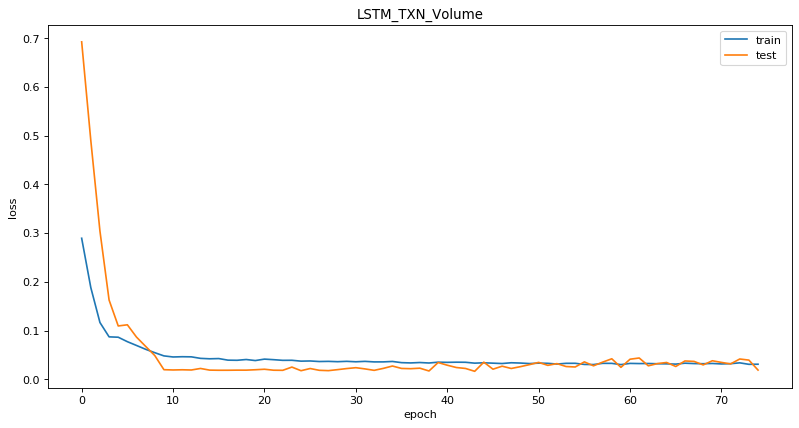

In [27]:
plt.figure(figsize=(12, 6), dpi=80)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.title('LSTM_TXN_Volume', fontsize='12')
plt.ylabel('loss', fontsize='10')
plt.xlabel('epoch', fontsize='10')
plt.legend()
plt.show()

In [28]:
# Model prediction
y_predict = model.predict(new_test_X)
y_predict.shape

(146, 1)

In [29]:
# Inversely normalize the predicted results
new_test_X2 = new_test_X.reshape((new_test_X.shape[0], new_test_X.shape[2]))
new_test_X2.shape

(146, 6)

In [30]:
new_y_test = concatenate((new_test_X2[:,:5], y_predict),axis=1)
new_y_test.shape

(146, 6)

In [31]:
inv_y_test = scaler.inverse_transform(new_y_test)
inv_y_predict = inv_y_test[:,-1]

In [32]:
# Inversely normalize the real results to scale
test_y = test_y.reshape((len(test_y), 1))
inv_y_train = concatenate((test_X[:,:5], test_y),axis=1)

In [33]:
inv_y_train = scaler.inverse_transform(inv_y_train)
inv_y = inv_y_train[:, -1]

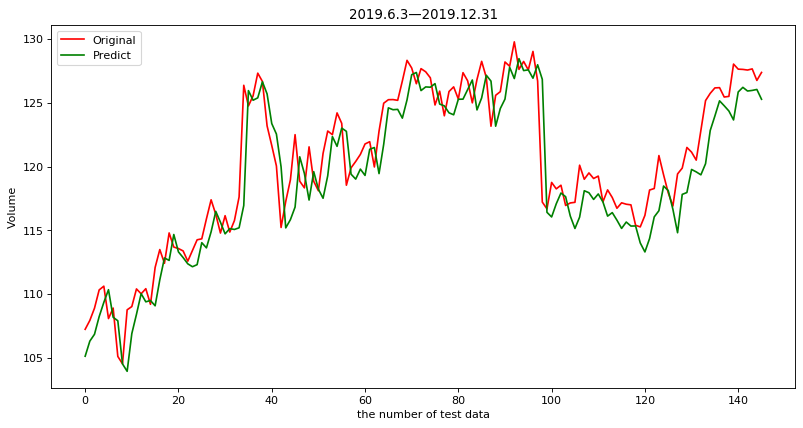

In [34]:
plt.figure(figsize=(12, 6), dpi=80)
plt.plot(inv_y, color='red', label='Original')
plt.plot(inv_y_predict, color='green', label='Predict')
plt.xlabel('the number of test data')
plt.ylabel('Volume')
plt.title('2019.6.3—2019.12.31')
plt.legend()
plt.show()

In [35]:
mse = mean_squared_error(inv_y, inv_y_predict)
rmse = sqrt(mean_squared_error(inv_y, inv_y_predict))
mae = mean_absolute_error(inv_y, inv_y_predict)
r_square = r2_score(inv_y, inv_y_predict)

In [36]:
print('均方误差: %.6f' % mse)
print('均方根误差: %.6f' % rmse)
print('平均绝对误差: %.6f' % mae)
print('R_square: %.6f' % r_square)

均方误差: 5.633653
均方根误差: 2.373532
平均绝对误差: 1.816395
R_square: 0.843311


In [37]:
def GM(x,y_label):
    # Import time series
    lan = []
    for i in range(len(x)):
        if i == len(x) - 1:
            continue
        # Calculate stepwise ratio 
        lan.append(x[i] / x[i + 1])
    x_1 = np.cumsum(x)
    # Construct data matrix B and data vector
    B = np.array([-1 / 2 * (x_1[i] + x_1[i + 1]) for i in range(len(x) - 1)])
    B = np.mat(np.vstack((B, np.ones((len(x) - 1,)))).T)
    Y = np.mat([x[i + 1] for i in range(len(x) - 1)]).T
    u = np.dot(np.dot(B.T.dot(B).I, B.T), Y)
    [a, b] = [u[0, 0], u[1, 0]]
    a_new, b = x[0] - b / a, b / a
    # Input the days that prediction needed
    y = 100
    y += len(x)
    x_predict = [x[0]]
    x_predict = x_predict + [a_new * (np.exp(-a * i) - np.exp(-a * (i - 1))) for i in range(1, y)]
    plt.figure(figsize=(10, 6), dpi=80)
    plt.plot(range(1200, 1510), x[1200:1510], range(1200, 1610), x_predict[1200:1610])
    plt.xlabel('Days')
    plt.ylabel(y_label)
    plt.legend(['Actual', 'Forecast'])
    plt.show()
    del x_predict[0:1199]
    return x_predict

In [38]:
def mistakes(n, A, f):
    #close=10;volume=500000;
    y=[]
    for i in range(0,n):
        x=2*pi*(i/n)
        y.append(A*sin(f*x))
    return y

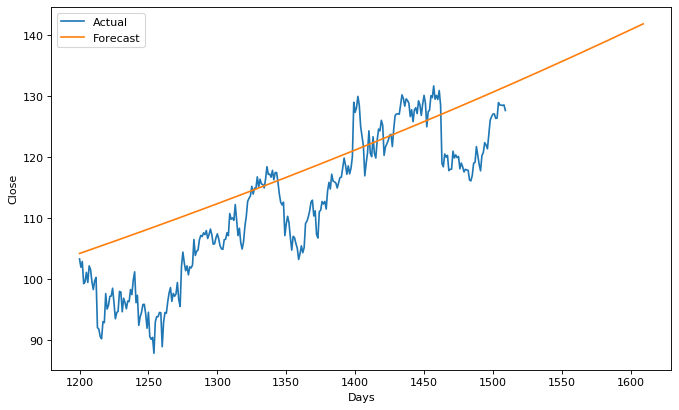

In [39]:
pre_clo=GM(data['Close'],"Close")

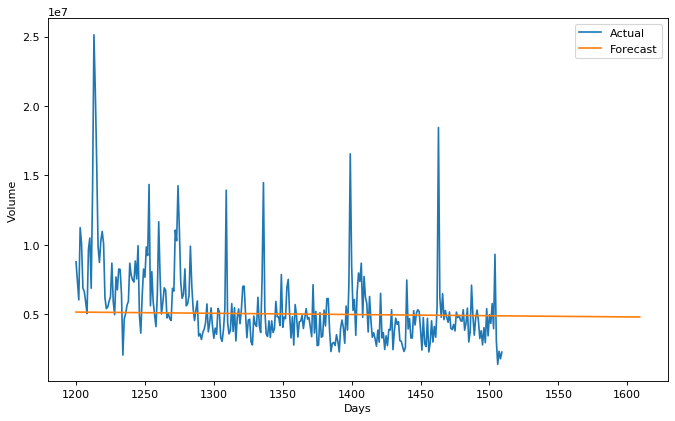

In [40]:
# Predict
pre=pd.DataFrame()
for i in range(0,99):
    pre_clo[i]+=mistakes(100,10,13)[i]
pre_vol=GM(data['Volume'],"Volume")
for i in range(0,99):
    pre_vol[i]+=mistakes(100,500000,9)[i]

In [41]:
pre["Close"] = pre_clo
pre["MA5_Close"] = moving_average(pre_clo, 5, 'simple')
pre["MA10_Close"] = moving_average(pre_clo, 10, 'simple')
pre["MA5_Volume"] = moving_average(pre_vol, 5, 'simple')
pre["MA10_Volume"] = moving_average(pre_vol, 10, 'simple')
meaning(pre,100)

本金 =  738165.289370131
期末持有股票 =  3720
佣金总计 =  2624.462722529548
收益率 =  0.1555028900267326


In [42]:
# plot prediction
data = [go.Scatter(x=pd.date_range(start='2020-1-1',periods=100,freq='D'),y=pre['MA5_Close'],name='MA5_Close'),
            go.Scatter(x=pd.date_range(start='2020-1-1',periods=100,freq='D'),y=pre['MA10_Close'],name='MA10_Close')]
layout = go.Layout(title='TXN-Close')
fig = go.Figure(data=data, layout=layout)
plot(fig)

'temp-plot.html'

In [ ]:
# Position on hand is greater than or equal to zero
# Gold cross, buy 50%; Death cross, sell 50%;
# Position = 1 million, commission rate = 0.0002;
# Rate of return = (sell price - buy price) X volume - sell volume X commission rate